## 자산별 VaR (정규분포 기반) 신뢰수준 99% 최근 1년

#### 1. 개별 주식 VaR (삼성전자)
#### 2. 주식 포트폴리오 VaR (삼성전자 + SK하이닉스)
#### 3. 채권 VaR (듀레이션 기반)
#### 4. 외환 VaR (수동 입력)

## 1. 자산별 VaR

In [5]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from pykrx import stock
from datetime import datetime, timedelta

# 공통 설정
end = datetime.today()
start = end - timedelta(days=252)
z = norm.ppf(0.01)  # 99% VaR


# 1. 개별 주식 VaR (삼성전자)
df = stock.get_market_ohlcv_by_date(start.strftime('%Y%m%d'), end.strftime('%Y%m%d'), "005930")
returns = df['종가'].pct_change().dropna()
mu_stock = returns.mean()
sigma_stock = returns.std()
value_stock = 10_000_000_000
var_stock = -(mu_stock + z * sigma_stock) * value_stock

# 2. 주식 포트폴리오 VaR (삼성전자 + SK하이닉스)
tickers = {"삼성전자": "005930", "SK하이닉스": "000660"}
weights = np.array([0.6, 0.4])
price_df = pd.DataFrame()

for name, code in tickers.items():
    price_df[name] = stock.get_market_ohlcv_by_date(
        start.strftime('%Y%m%d'), end.strftime('%Y%m%d'), code
    )['종가']

log_returns = np.log(price_df / price_df.shift(1)).dropna()
mu_port = np.dot(weights, log_returns.mean())
cov_matrix = log_returns.cov()
sigma_port = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
var_portfolio = -(mu_port + z * sigma_port) * value_stock

# 3. 채권 VaR (듀레이션 기반)
duration = 5
rate_vol = 0.015
var_bond = duration * z * rate_vol * value_stock

# 4. 외환 VaR (수동 입력)
mu_fx = 0.0001
sigma_fx = 0.01
spot_rate = 1350
usd_exposure = 10_000_000
value_krw = usd_exposure * spot_rate
var_fx = -(mu_fx + z * sigma_fx) * value_krw

# 결과 출력
results = pd.DataFrame({
    "자산유형": ["개별 주식", "주식 포트폴리오", "채권", "외환"],
    "VaR(99%) 금액": [round(var_stock), round(var_portfolio), round(var_bond), round(var_fx)],
    "단위": ["원", "원", "원", "원"]
})
print(results)


       자산유형  VaR(99%) 금액 단위
0     개별 주식    478733141  원
1  주식 포트폴리오    481909177  원
2        채권  -1744760906  원
3        외환    312706963  원


## 2. 시각화

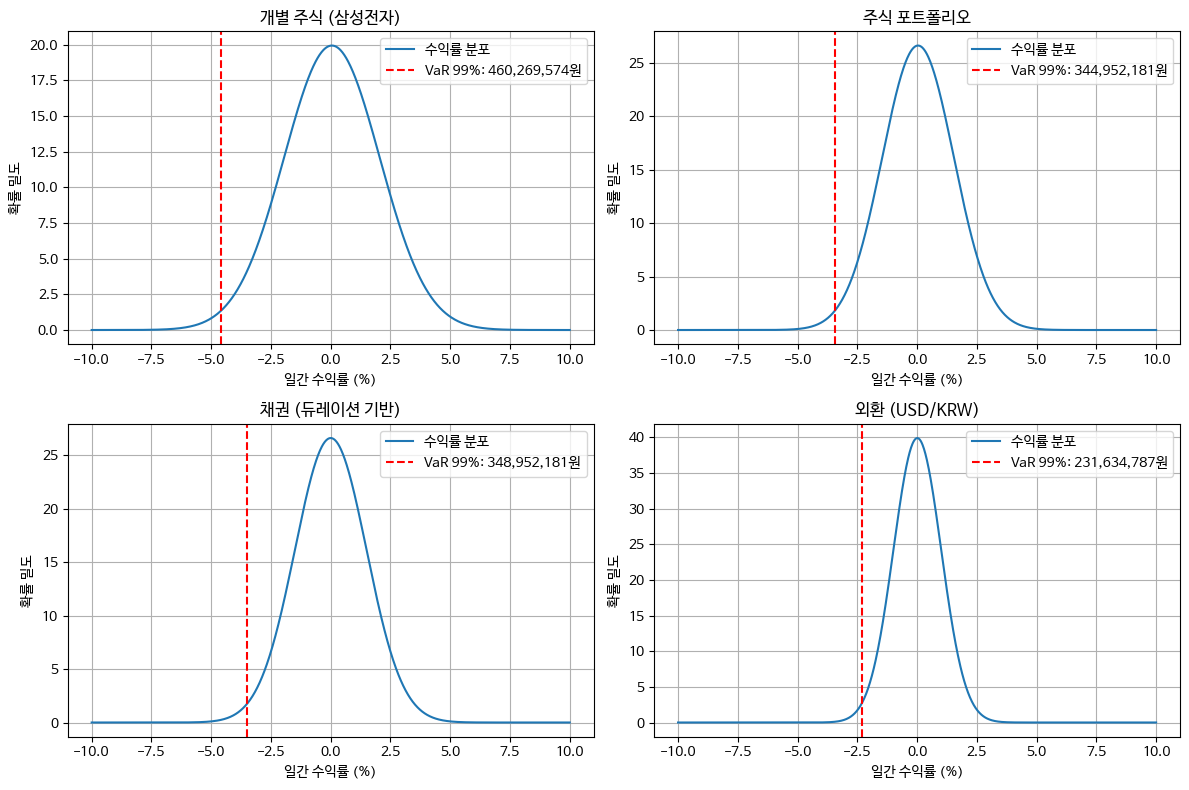

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 자산별 매개변수 설정
mu_sigma_dict = {
    "개별 주식 (삼성전자)": (0.0005, 0.02),
    "주식 포트폴리오": (0.0004, 0.015),
    "채권 (듀레이션 기반)": (0.0, 0.015),  # 채권은 보통 수익률 대신 금리 변화 민감도 기준
    "외환 (USD/KRW)": (0.0001, 0.01)
}

portfolio_value = 10_000_000_000  # 100억 원
z = norm.ppf(0.01)  # 99% VaR

# 시각화
plt.figure(figsize=(12, 8))
x = np.linspace(-0.1, 0.1, 1000)

for i, (asset, (mu, sigma)) in enumerate(mu_sigma_dict.items(), 1):
    rv = norm(mu, sigma)
    losses = (rv.ppf(1 - norm.cdf(x))) * portfolio_value
    plt.subplot(2, 2, i)
    plt.plot(x * 100, rv.pdf(x), label="수익률 분포")
    var = (mu + z * sigma) * portfolio_value
    plt.axvline((mu + z * sigma) * 100, color='red', linestyle='--', label=f'VaR 99%: {int(-var):,}원')
    plt.title(asset)
    plt.xlabel("일간 수익률 (%)")
    plt.ylabel("확률 밀도")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


## 3.  CVaR (정규분포 기반)

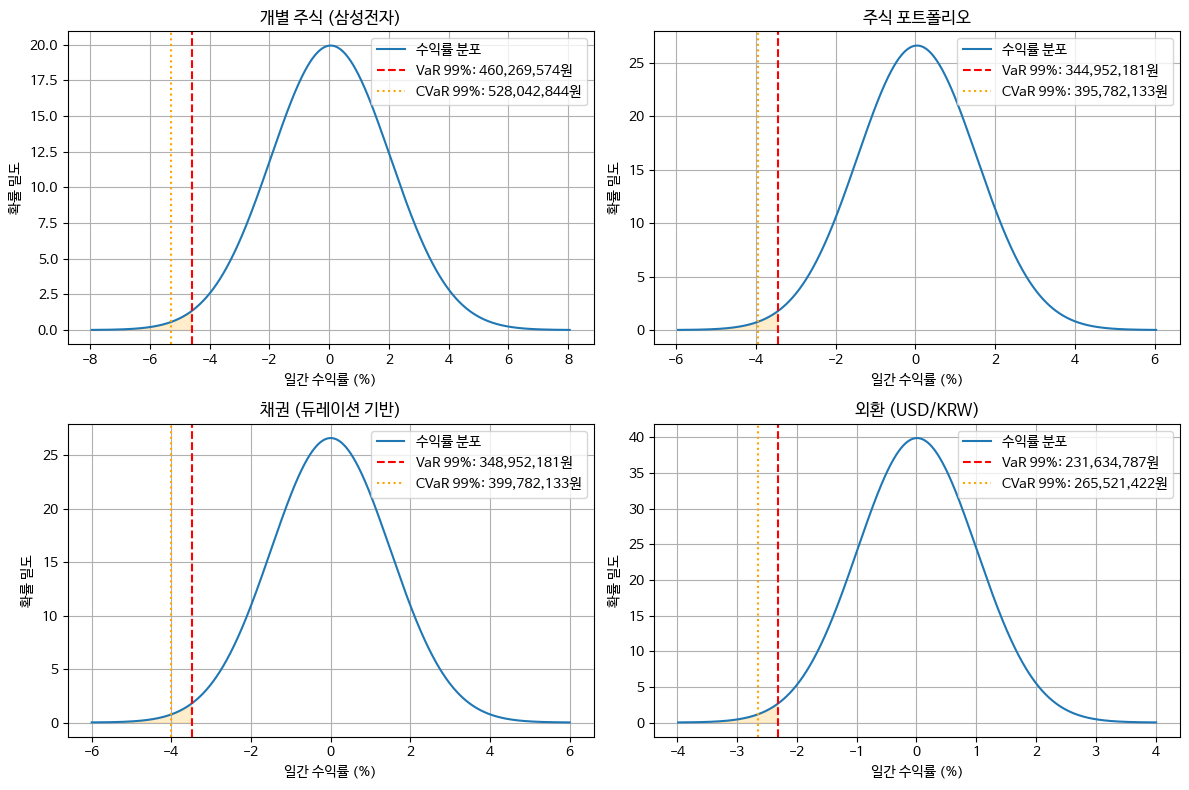

In [7]:
# CVaR 계산 및 시각화 포함
plt.figure(figsize=(12, 8))

for i, (asset, (mu, sigma)) in enumerate(mu_sigma_dict.items(), 1):
    rv = norm(mu, sigma)
    x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 1000)
    y = rv.pdf(x)
    
    var_threshold = mu + z * sigma
    cvar = rv.expect(lambda x: x, lb=-np.inf, ub=var_threshold) / norm.cdf(z)

    # 금액 기준으로 변환
    var_amount = var_threshold * portfolio_value
    cvar_amount = cvar * portfolio_value

    plt.subplot(2, 2, i)
    plt.plot(x * 100, y, label="수익률 분포")
    plt.axvline(var_threshold * 100, color='red', linestyle='--', label=f'VaR 99%: {int(-var_amount):,}원')
    plt.axvline(cvar * 100, color='orange', linestyle=':', label=f'CVaR 99%: {int(-cvar_amount):,}원')
    plt.fill_between(x * 100, 0, y, where=(x <= var_threshold), color='orange', alpha=0.2)
    
    plt.title(asset)
    plt.xlabel("일간 수익률 (%)")
    plt.ylabel("확률 밀도")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


## 4. 히스토리컬/몬테카를로 기반 

      방법  VaR (%)  CVaR (%)      VaR (금액)     CVaR (금액)
0  히스토리컬  -4.2243   -6.0573 -4.224254e+08 -6.057317e+08
1  몬테카를로  -4.7440   -5.4240 -4.744013e+08 -5.423993e+08


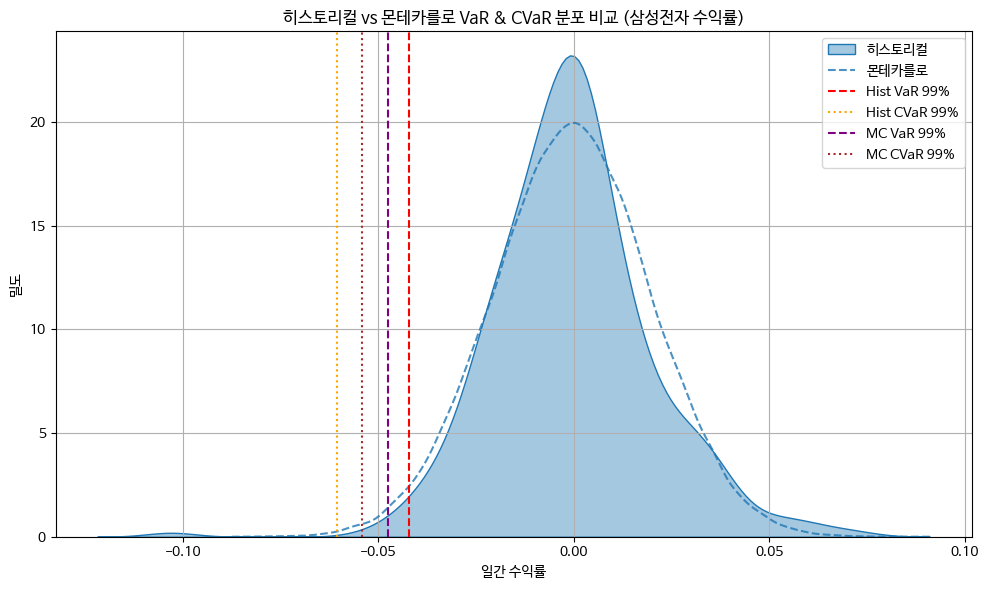

In [8]:
from pykrx import stock
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 수집 (최근 2년)
start = (datetime.today() - timedelta(days=252 * 2)).strftime('%Y%m%d')
end = datetime.today().strftime('%Y%m%d')
df = stock.get_market_ohlcv_by_date(start, end, "005930")
returns = df["종가"].pct_change().dropna()
ret_arr = returns.values

# 설정
alpha = 0.99
portfolio_value = 10_000_000_000

# 1. 히스토리컬
hist_var = np.percentile(ret_arr, (1 - alpha) * 100)
hist_cvar = ret_arr[ret_arr <= hist_var].mean()

# 2. 몬테카를로
mu = ret_arr.mean()
sigma = ret_arr.std()
mc_sim = np.random.normal(mu, sigma, 100000)

mc_var = np.percentile(mc_sim, (1 - alpha) * 100)
mc_cvar = mc_sim[mc_sim <= mc_var].mean()

# 결과 테이블
summary_df = pd.DataFrame({
    "방법": ["히스토리컬", "몬테카를로"],
    "VaR (%)": [hist_var * 100, mc_var * 100],
    "CVaR (%)": [hist_cvar * 100, mc_cvar * 100],
    "VaR (금액)": [hist_var * portfolio_value, mc_var * portfolio_value],
    "CVaR (금액)": [hist_cvar * portfolio_value, mc_cvar * portfolio_value]
})
print(summary_df.round(4))

# 시각화
plt.figure(figsize=(10, 6))
sns.kdeplot(ret_arr, label="히스토리컬", fill=True, alpha=0.4)
sns.kdeplot(mc_sim, label="몬테카를로", linestyle='--', alpha=0.8)

plt.axvline(hist_var, color='red', linestyle='--', label=f'Hist VaR 99%')
plt.axvline(hist_cvar, color='orange', linestyle=':', label=f'Hist CVaR 99%')
plt.axvline(mc_var, color='purple', linestyle='--', label=f'MC VaR 99%')
plt.axvline(mc_cvar, color='brown', linestyle=':', label=f'MC CVaR 99%')

plt.title("히스토리컬 vs 몬테카를로 VaR & CVaR 분포 비교 (삼성전자 수익률)")
plt.xlabel("일간 수익률")
plt.ylabel("밀도")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
